In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.stats import mstats
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,accuracy_score, precision_score,roc_auc_score,f1_score,confusion_matrix

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.family'] = 'Malgun Gothic'

import warnings
warnings.filterwarnings('ignore')

c:\Users\Master\anaconda3\lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## 0.파일 불러오기

In [2]:
df = pd.read_csv('../data/processed_data/재무비율_재무지표_concat.csv', index_col=0)
df.head()

,회사명,거래소코드,회계년도,소속코드_df1,통계청 한국표준산업분류 코드 10차(대분류)_df1,산업코드_df1,산업명_df1,상장일_df1,상장폐지일_df1,현금및현금성자산(IFRS),...,자본분배율(IFRS),이윤분배율(IFRS),법인세비용차감전(계속사업)손익(IFRS)(백만원),인건비(IFRS)(백만원),금융비용(IFRS)(백만원),임차료(IFRS)(백만원),세금과공과(IFRS)(백만원),감가상각비(IFRS)(백만원),종업원수(IFRS),label_df2
0,(주)다이나믹디자인,145210,2015,1,29,32902,기타 기계 및 장비 제조업,2015-03-19,0,10376890.0,...,29.18,2.06,1548.77,46876.84,3589.40,0.0,0.0,14203.75,150.0,1
1,(주)다이나믹디자인,145210,2016,1,29,32902,기타 기계 및 장비 제조업,2015-03-19,0,15192647.0,...,0.00,0.00,-11379.61,0.00,0.00,0.0,0.0,0.00,134.0,1
2,(주)다이나믹디자인,145210,2017,1,29,32902,기타 기계 및 장비 제조업,2015-03-19,0,6564156.0,...,-90.09,-161.93,-34429.26,39598.55,3990.88,0.0,0.0,11694.91,526.0,1
3,(주)대우건설,47040,2012,1,41,64101,종합 건설업,2001-03-23,0,388440274.0,...,40.72,12.78,227947.72,802635.00,94086.89,124047.0,54145.0,51212.00,5192.0,0
4,(주)대우건설,47040,2013,1,41,64101,종합 건설업,2001-03-23,0,409596263.0,...,-125.45,-177.13,-839724.66,913926.00,86015.38,123239.0,62921.0,59003.00,6382.0,0


In [3]:
X_data = df[df.columns[9:-1]]
y_data = df['label_df2']

## 1.데이터 split

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,test_size=0.3,stratify=y_data,random_state = 40)

In [5]:
n, d = X_train.shape
print("number of feature:", d)
print("number of feature:", n)

number of feature: 194
number of feature: 272


## 2. 스케일링
- standard + log
- minmax + log

In [6]:
# 로그 변환할 컬럼들 지정
columns_to_log_transform = ['현금및현금성자산(IFRS)', '유동금융자산(IFRS)', '매출채권 및 기타유동채권(IFRS)',
       '상각후원가측정 유가증권(IFRS)', '매출채권(IFRS)', '미수금(IFRS)', '단기대여금(IFRS)',
       '선급금(IFRS)', '기타유동자산(IFRS)', '상품(IFRS)', '제품(IFRS)', '원재료(부재료)(IFRS)',
       '토지(IFRS)', '건물 및 부속설비(IFRS)', '기계장치(IFRS)', '차량운반구(IFRS)', '공구',
       '회원권(IFRS)', '배출권자산(IFRS)', '매입채무(IFRS)', '미지급금(IFRS)', '미지급비용(IFRS)',
       '선수금(IFRS)', '당기법인세부채(미지급법인세)(IFRS)', '기타유동부채(IFRS)', '장기차입금(IFRS)',
       '보통주자본금(IFRS)', '주식발행초과금(IFRS)', '자기주식(IFRS)', '기타포괄손익누계액(IFRS)',
       '이익준비금(IFRS)', '미처분이익잉여금(결손금)(IFRS)', '매출액(수익)(IFRS)', '제품매출액(IFRS)',
       '기타수익(IFRS)', '종업원 급여비용(IFRS)', '급여(IFRS)', '퇴직급여(IFRS)', '복리후생비(IFRS)',
       '보험료(IFRS)', '여비교통비(IFRS)', '임차료(IFRS)', '접대비(IFRS)', '감가상각비(IFRS)',
       '광고선전비(IFRS)', '차량유지비(IFRS)', '연구개발비(IFRS)', '대손상각비(IFRS)', '기타(IFRS)',
       '이자수익(IFRS)', '외환차손(IFRS).1', '외화환산손실(IFRS).1', '법인세비용(IFRS)','부가가치(IFRS)(백만원)',
       '법인세비용차감전(계속사업)손익(IFRS)(백만원)', '인건비(IFRS)(백만원)', '금융비용(IFRS)(백만원)',
       '임차료(IFRS)(백만원)', '세금과공과(IFRS)(백만원)', '감가상각비(IFRS)(백만원)', '종업원수(IFRS)']

# 1. 로그 변환 적용
X_train[columns_to_log_transform] = X_train[columns_to_log_transform].apply(np.log1p)

# 2. 나머지 컬럼들에 대해 표준화 적용
columns_to_scale = X_train.columns.difference(columns_to_log_transform)
scaler = StandardScaler()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

In [7]:
# 1. 로그 변환 적용
X_test[columns_to_log_transform] = X_test[columns_to_log_transform].apply(np.log1p)

# 2. 나머지 컬럼들에 대해 표준화 적용

X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

## 3. 모델링

### 3-1.CatBoost

In [8]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# CatBoost 모델 생성
model = CatBoostClassifier(iterations=100, learning_rate=0.1, loss_function='Logloss')

# 모델 학습
model.fit(X_train, y_train, verbose=0)

# 테스트 데이터에 대한 예측
y_pred2 = model.predict(X_test)

# 다양한 평가 지표 출력
accuracy = accuracy_score(y_test, y_pred2)
precision = precision_score(y_test, y_pred2)
recall = recall_score(y_test, y_pred2)
f1 = f1_score(y_test, y_pred2)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.8205128205128205
Precision: 0.8269230769230769
Recall: 0.9662921348314607
F1 Score: 0.8911917098445596


### 3-2.Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Decision Tree 모델 생성
model = DecisionTreeClassifier()

# 모델 학습
model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 다양한 평가 지표 출력
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


ValueError: Input X contains NaN.
DecisionTreeClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### 2-4.나이브베이즈

In [103]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# 기본 나이브 베이즈 분류기 생성
base_model = GaussianNB()

# 배깅 분류기 생성
model = BaggingClassifier(base_model, n_estimators=10, random_state=42)

# 모델 학습
model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 다양한 평가 지표 출력
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.3504273504273504
Precision: 0.8421052631578947
Recall: 0.1797752808988764
F1 Score: 0.2962962962962963


In [104]:
df2 = pd.DataFrame()

In [105]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

rf_train = [accuracy_score(y_train, y_pred_train),precision_score(y_train, y_pred_train),recall_score(y_train, y_pred_train),f1_score(y_train, y_pred_train),roc_auc_score(y_train, y_pred_train)]
rf_test = [accuracy_score(y_test, y_pred_test),precision_score(y_test, y_pred_test),recall_score(y_test, y_pred_test),f1_score(y_test, y_pred_test),roc_auc_score(y_test, y_pred_test)]

df2['rf_train'] = rf_train
df2['rf_test'] = rf_test


print(confusion_matrix(y_test,y_pred_test))

[[12 16]
 [ 4 85]]


In [106]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

xgb_train = [accuracy_score(y_train, y_pred_train),precision_score(y_train, y_pred_train),recall_score(y_train, y_pred_train),f1_score(y_train, y_pred_train),roc_auc_score(y_train, y_pred_train)]
xgb_test = [accuracy_score(y_test, y_pred_test),precision_score(y_test, y_pred_test),recall_score(y_test, y_pred_test),f1_score(y_test, y_pred_test),roc_auc_score(y_test, y_pred_test)]

df2['xgb_train'] = xgb_train
df2['xgb_test'] = xgb_test


print(confusion_matrix(y_test,y_pred_test))

[[10 18]
 [ 4 85]]


In [107]:
# lgb = LGBMClassifier(random_state=42)
# lgb.fit(X_train, y_train)
# y_pred_train = lgb.predict(X_train)
# y_pred_test = lgb.predict(X_test)

# lgb_train =[accuracy_score(y_train, y_pred_train),precision_score(y_train, y_pred_train),recall_score(y_train, y_pred_train),f1_score(y_train, y_pred_train),roc_auc_score(y_train, y_pred_train)]
# lgb_test = [accuracy_score(y_test, y_pred_test),precision_score(y_test, y_pred_test),recall_score(y_test, y_pred_test),f1_score(y_test, y_pred_test),roc_auc_score(y_test, y_pred_test)]

# df2['lgb_train'] = lgb_train
# df2['lgb_test'] = lgb_test


# print(confusion_matrix(y_test,y_pred_test))

In [108]:
cat = CatBoostClassifier(random_state=42, verbose=0)
cat.fit(X_train, y_train)
y_pred_train = cat.predict(X_train)
y_pred_test = cat.predict(X_test)

cat_train = [accuracy_score(y_train, y_pred_train),precision_score(y_train, y_pred_train),recall_score(y_train, y_pred_train),f1_score(y_train, y_pred_train),roc_auc_score(y_train, y_pred_train)]
cat_test = [accuracy_score(y_test, y_pred_test),precision_score(y_test, y_pred_test),recall_score(y_test, y_pred_test),f1_score(y_test, y_pred_test),roc_auc_score(y_test, y_pred_test)]

df2['cat_train'] = cat_train
df2['cat_test'] = cat_test


print(confusion_matrix(y_test,y_pred_test))

[[12 16]
 [ 2 87]]


In [109]:
svc_clf = SVC() 
svc_clf.fit(X_train,y_train)
y_pred_train = svc_clf.predict(X_train)
y_pred_test = svc_clf.predict(X_test)

svc_clf_train =[accuracy_score(y_train, y_pred_train),precision_score(y_train, y_pred_train),recall_score(y_train, y_pred_train),f1_score(y_train, y_pred_train),roc_auc_score(y_train, y_pred_train)]
svc_clf_test = [accuracy_score(y_test, y_pred_test),precision_score(y_test, y_pred_test),recall_score(y_test, y_pred_test),f1_score(y_test, y_pred_test),roc_auc_score(y_test, y_pred_test)]

df2['svm_train'] = svc_clf_train
df2['svm_test'] = svc_clf_test


print(confusion_matrix(y_test,y_pred_test))

[[ 1 27]
 [ 0 89]]


In [110]:
df2.index = ['accuracy','precision','recall','f1-score','roc-auc']
df2

,rf_train,rf_test,xgb_train,xgb_test,cat_train,cat_test,svm_train,svm_test
accuracy,1.0,0.829060,1.0,0.811966,1.0,0.846154,0.775735,0.769231
precision,1.0,0.841584,1.0,0.825243,1.0,0.844660,0.772388,0.767241
recall,1.0,0.955056,1.0,0.955056,1.0,0.977528,1.000000,1.000000
f1-score,1.0,0.894737,1.0,0.885417,1.0,0.906250,0.871579,0.868293
roc-auc,1.0,0.691814,1.0,0.656100,1.0,0.703050,0.530769,0.517857


# 이상치처리 2%

In [111]:
X_data_winsor_2, winsorization_info_2 = apply_winsorization_based_on_outliers(X_data, pct = 0.02)

In [112]:
winsorization_info_2

{'현금및현금성자산(IFRS)': '상위 2.0% 윈저라이징',
 '유동금융자산(IFRS)': '상위 2.0% 윈저라이징',
 '매출채권 및 기타유동채권(IFRS)': '상위 2.0% 윈저라이징',
 '매출채권(IFRS)': '상위 2.0% 윈저라이징',
 '미수금(IFRS)': '상위 2.0% 윈저라이징',
 '단기대여금(IFRS)': '상위 2.0% 윈저라이징',
 '선급금(IFRS)': '상위 2.0% 윈저라이징',
 '기타유동자산(IFRS)': '상위 2.0% 윈저라이징',
 '상품(IFRS)': '상위 2.0% 윈저라이징',
 '제품(IFRS)': '상위 2.0% 윈저라이징',
 '원재료(부재료)(IFRS)': '상위 2.0% 윈저라이징',
 '토지(IFRS)': '상위 2.0% 윈저라이징',
 '건물 및 부속설비(IFRS)': '상위 2.0% 윈저라이징',
 '기계장치(IFRS)': '상위 2.0% 윈저라이징',
 '차량운반구(IFRS)': '상위 2.0% 윈저라이징',
 '공구': '상위 2.0% 윈저라이징',
 '회원권(IFRS)': '상위 2.0% 윈저라이징',
 '매입채무(IFRS)': '상위 2.0% 윈저라이징',
 '미지급금(IFRS)': '상위 2.0% 윈저라이징',
 '미지급비용(IFRS)': '상위 2.0% 윈저라이징',
 '선수금(IFRS)': '상위 2.0% 윈저라이징',
 '당기법인세부채(미지급법인세)(IFRS)': '상하위 2.0% 윈저라이징',
 '기타유동부채(IFRS)': '상위 2.0% 윈저라이징',
 '장기차입금(IFRS)': '상위 2.0% 윈저라이징',
 '보통주자본금(IFRS)': '상위 2.0% 윈저라이징',
 '주식발행초과금(IFRS)': '상위 2.0% 윈저라이징',
 '자기주식(IFRS)': '하위 2.0% 윈저라이징',
 '기타포괄손익누계액(IFRS)': '상하위 2.0% 윈저라이징',
 '이익준비금(IFRS)': '상위 2.0% 윈저라이징',
 '미처분이익잉여금(결손금)(IFRS)': '상하위 2.0% 

In [113]:
# 이상치 처리 전 후
display(before_winsor_feature.describe(), X_data_winsor_2.describe())

,현금및현금성자산(IFRS),유동금융자산(IFRS),매출채권 및 기타유동채권(IFRS),상각후원가측정 유가증권(IFRS),매출채권(IFRS),미수금(IFRS),단기대여금(IFRS),선급금(IFRS),기타유동자산(IFRS),상품(IFRS),...,노동소득분배율(IFRS),자본분배율(IFRS),이윤분배율(IFRS),법인세비용차감전(계속사업)손익(IFRS)(백만원),인건비(IFRS)(백만원),금융비용(IFRS)(백만원),임차료(IFRS)(백만원),세금과공과(IFRS)(백만원),감가상각비(IFRS)(백만원),종업원수(IFRS)
count,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,...,389.000000,389.000000,389.000000,3.890000e+02,3.890000e+02,389.000000,389.000000,389.000000,389.000000,389.000000
mean,8.232927e+07,5.939977e+07,2.863112e+08,6.233210e+04,1.156015e+08,3.079093e+07,1.268258e+07,3.901258e+07,4.114176e+07,6.463591e+06,...,161.160154,-80.954499,-232.377558,1.559327e+04,9.478764e+04,9165.102982,5618.652057,832.450591,22192.300437,768.066838
std,2.911515e+08,2.210259e+08,1.025248e+09,1.042155e+06,4.057154e+08,1.250409e+08,5.284769e+07,1.551063e+08,1.747595e+08,2.641326e+07,...,1477.557172,1475.930332,2738.067051,2.784824e+05,2.875997e+05,45912.801525,43766.772036,5145.486096,65427.520577,1886.967186
min,8.790000e+02,0.000000e+00,2.830360e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,-28477.690000,-50846.420000,-3.124361e+06,-2.386364e+04,-54363.000000,-194.640000,0.000000,0.000000,0.000000
25%,2.503144e+06,1.051000e+06,9.056679e+06,0.000000e+00,8.167975e+06,3.745310e+05,2.000000e+03,3.498490e+05,2.616570e+05,0.000000e+00,...,28.020000,0.000000,-13.330000,-1.002139e+04,5.570410e+03,128.840000,0.000000,0.000000,1350.230000,83.000000
50%,8.460020e+06,4.120500e+06,2.147539e+07,0.000000e+00,1.899071e+07,1.494613e+06,7.200000e+05,1.742473e+06,1.002740e+06,2.980640e+05,...,55.230000,26.840000,0.000000,2.779400e+02,1.280991e+04,1174.800000,0.000000,0.000000,3040.440000,187.000000
75%,3.063622e+07,1.714959e+07,6.569940e+07,0.000000e+00,4.292005e+07,7.573210e+06,5.092189e+06,7.128426e+06,4.604050e+06,2.415525e+06,...,76.440000,49.370000,21.320000,1.066846e+04,3.572547e+04,3411.040000,240.620000,0.000000,9785.160000,380.000000
max,2.542381e+09,2.099634e+09,7.980449e+09,2.029100e+07,3.595024e+09,1.095078e+09,7.598982e+08,1.743728e+09,1.752561e+09,3.214640e+08,...,28577.690000,92.530000,77.600000,1.571030e+06,2.055868e+06,459499.000000,602155.270000,62921.000000,550894.000000,13602.000000


,현금및현금성자산(IFRS),유동금융자산(IFRS),매출채권 및 기타유동채권(IFRS),상각후원가측정 유가증권(IFRS),매출채권(IFRS),미수금(IFRS),단기대여금(IFRS),선급금(IFRS),기타유동자산(IFRS),상품(IFRS),...,노동소득분배율(IFRS),자본분배율(IFRS),이윤분배율(IFRS),법인세비용차감전(계속사업)손익(IFRS)(백만원),인건비(IFRS)(백만원),금융비용(IFRS)(백만원),임차료(IFRS)(백만원),세금과공과(IFRS)(백만원),감가상각비(IFRS)(백만원),종업원수(IFRS)
count,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,...,389.000000,389.000000,389.000000,389.000000,3.890000e+02,389.000000,389.000000,389.000000,389.000000,389.000000
mean,6.842550e+07,4.569733e+07,2.470845e+08,6.233210e+04,8.582090e+07,2.394592e+07,1.076226e+07,2.967142e+07,3.342635e+07,4.837201e+06,...,67.970848,12.234807,-33.206658,23552.974910,9.031293e+04,6645.709512,5618.652057,832.450591,19010.608895,700.614396
std,1.999303e+08,1.302532e+08,7.838207e+08,1.042155e+06,2.008477e+08,7.937987e+07,3.515777e+07,9.015009e+07,1.209563e+08,1.273135e+07,...,75.481083,67.759073,128.362922,165795.436507,2.605101e+05,22807.802144,43766.772036,5145.486096,45897.161855,1515.091726
min,8.790000e+02,0.000000e+00,2.830360e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,-308.510000,-641.990000,-319669.000000,-2.386364e+04,-21550.810000,-194.640000,0.000000,0.000000,0.000000
25%,2.503144e+06,1.051000e+06,9.056679e+06,0.000000e+00,8.167975e+06,3.745310e+05,2.000000e+03,3.498490e+05,2.616570e+05,0.000000e+00,...,28.020000,0.000000,-13.330000,-10021.390000,5.570410e+03,128.840000,0.000000,0.000000,1350.230000,83.000000
50%,8.460020e+06,4.120500e+06,2.147539e+07,0.000000e+00,1.899071e+07,1.494613e+06,7.200000e+05,1.742473e+06,1.002740e+06,2.980640e+05,...,55.230000,26.840000,0.000000,277.940000,1.280991e+04,1174.800000,0.000000,0.000000,3040.440000,187.000000
75%,3.063622e+07,1.714959e+07,6.569940e+07,0.000000e+00,4.292005e+07,7.573210e+06,5.092189e+06,7.128426e+06,4.604050e+06,2.415525e+06,...,76.440000,49.370000,21.320000,10668.460000,3.572547e+04,3411.040000,240.620000,0.000000,9785.160000,380.000000
max,1.235931e+09,6.998510e+08,4.434922e+09,2.029100e+07,1.063987e+09,4.889715e+08,1.976308e+08,4.665740e+08,7.264455e+08,7.118218e+07,...,408.510000,92.530000,77.600000,898137.000000,1.540530e+06,134006.230000,602155.270000,62921.000000,240711.000000,7468.000000


이상치 처리 후 시각화

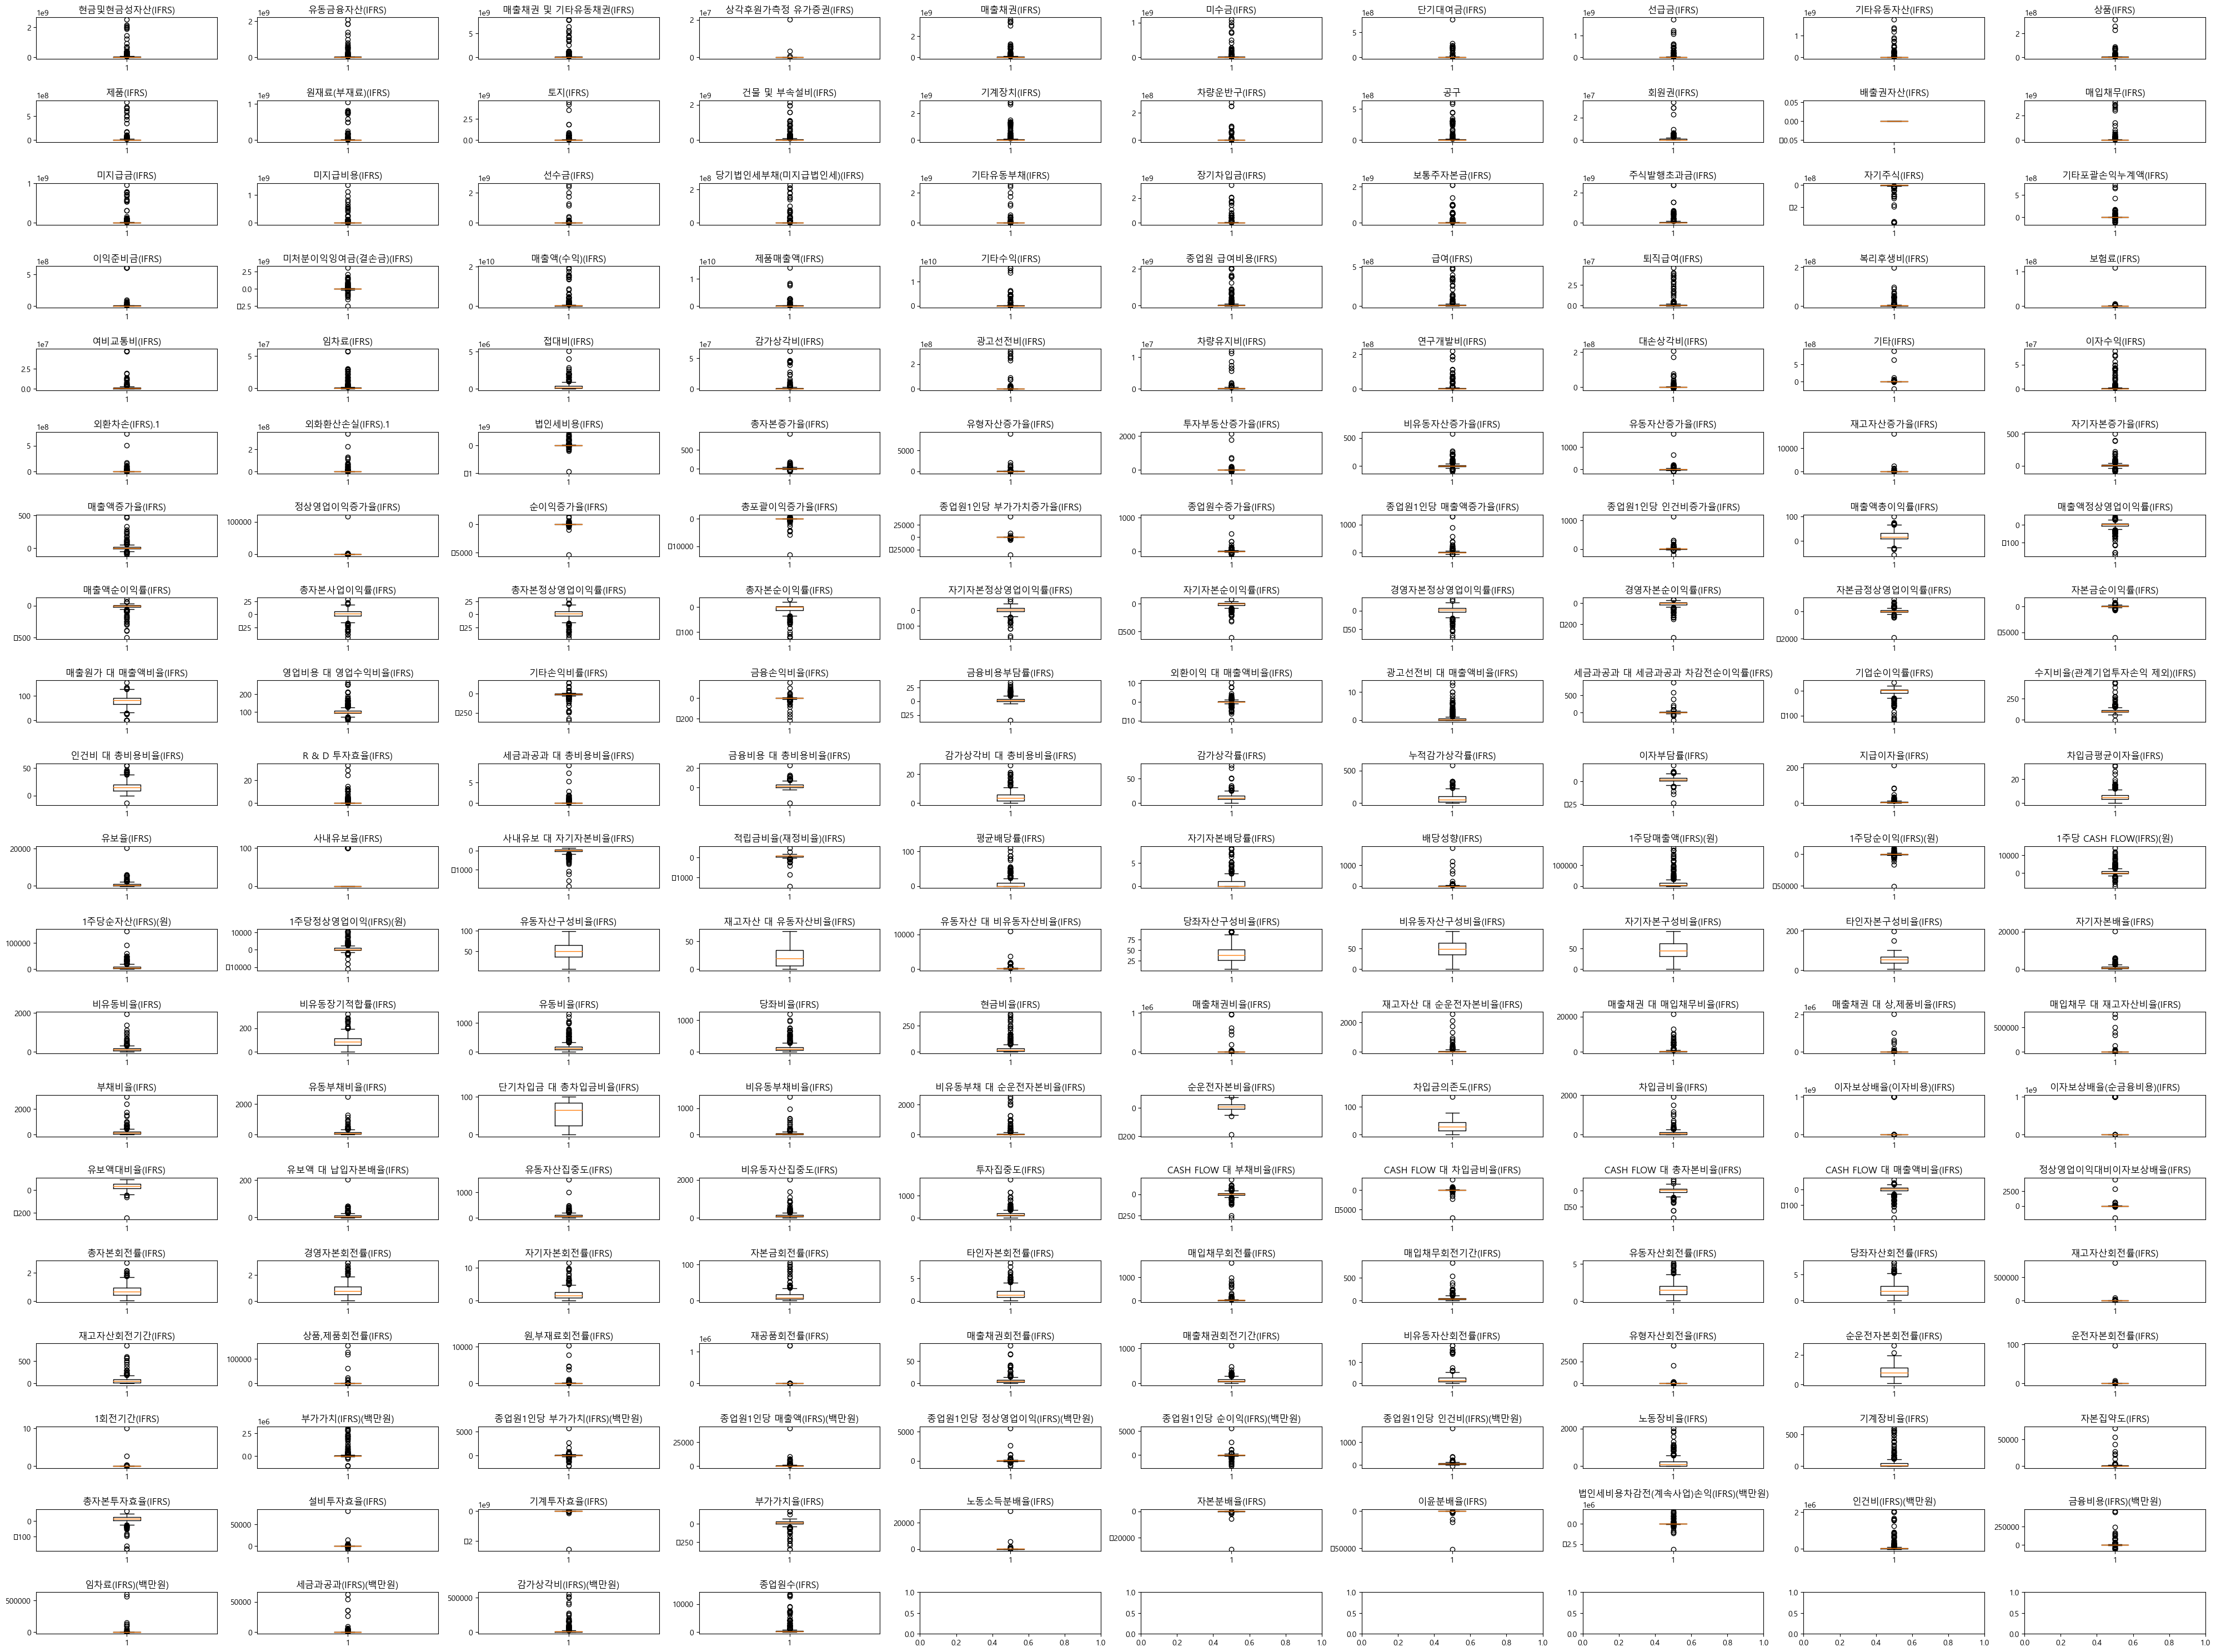

In [114]:
selected_variables = X_data_winsor_2
# 5x4 subplot 생성
fig, axes = plt.subplots(20, 10, figsize=(40, 30))
axes = axes.flatten()  # 2D axes 배열을 1D 배열로 변환

for i, var in enumerate(selected_variables):
    # i번째 axes에 i번째 변수의 히스토그램을 그림
    axes[i].boxplot(df[var])
    axes[i].set_title(var)  # 각 히스토그램에 변수 이름을 제목으로 설정

plt.tight_layout()  # subplot 간격 조정
plt.show()

## 1.데이터 split

In [115]:
X_train,X_test,y_train,y_test = train_test_split(X_data_winsor_2,y_data,test_size=0.3,stratify=y_data,random_state = 40)

In [116]:
n, d = X_train.shape
print("number of feature:", d)
print("number of feature:", n)

number of feature: 194
number of feature: 272


## 2. 모델링

### 2-2.catboost

In [117]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# CatBoost 모델 생성
model = CatBoostClassifier(iterations=100, learning_rate=0.1, loss_function='Logloss')

# 모델 학습
model.fit(X_train, y_train, verbose=0)

# 테스트 데이터에 대한 예측
y_pred2 = model.predict(X_test)

# 다양한 평가 지표 출력
accuracy = accuracy_score(y_test, y_pred2)
precision = precision_score(y_test, y_pred2)
recall = recall_score(y_test, y_pred2)
f1 = f1_score(y_test, y_pred2)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.8376068376068376
Precision: 0.8365384615384616
Recall: 0.9775280898876404
F1 Score: 0.9015544041450776


### 2-3.Decision Tree

In [118]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Decision Tree 모델 생성
model = DecisionTreeClassifier()

# 모델 학습
model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 다양한 평가 지표 출력
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.7692307692307693
Precision: 0.8297872340425532
Recall: 0.8764044943820225
F1 Score: 0.8524590163934426


### 2-4.나이브베이즈

In [119]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# 기본 나이브 베이즈 분류기 생성
base_model = GaussianNB()

# 배깅 분류기 생성
model = BaggingClassifier(base_model, n_estimators=10, random_state=42)

# 모델 학습
model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 다양한 평가 지표 출력
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.3504273504273504
Precision: 0.8095238095238095
Recall: 0.19101123595505617
F1 Score: 0.3090909090909091


In [120]:
df3 = pd.DataFrame()

In [121]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

rf_train = [accuracy_score(y_train, y_pred_train),precision_score(y_train, y_pred_train),recall_score(y_train, y_pred_train),f1_score(y_train, y_pred_train),roc_auc_score(y_train, y_pred_train)]
rf_test = [accuracy_score(y_test, y_pred_test),precision_score(y_test, y_pred_test),recall_score(y_test, y_pred_test),f1_score(y_test, y_pred_test),roc_auc_score(y_test, y_pred_test)]

df3['rf_train'] = rf_train
df3['rf_test'] = rf_test


print(confusion_matrix(y_test,y_pred_test))

[[12 16]
 [ 4 85]]


In [122]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

xgb_train = [accuracy_score(y_train, y_pred_train),precision_score(y_train, y_pred_train),recall_score(y_train, y_pred_train),f1_score(y_train, y_pred_train),roc_auc_score(y_train, y_pred_train)]
xgb_test = [accuracy_score(y_test, y_pred_test),precision_score(y_test, y_pred_test),recall_score(y_test, y_pred_test),f1_score(y_test, y_pred_test),roc_auc_score(y_test, y_pred_test)]

df3['xgb_train'] = xgb_train
df3['xgb_test'] = xgb_test


print(confusion_matrix(y_test,y_pred_test))

[[13 15]
 [ 2 87]]


In [123]:
# lgb = LGBMClassifier(random_state=42)
# lgb.fit(X_train, y_train)
# y_pred_train = lgb.predict(X_train)
# y_pred_test = lgb.predict(X_test)

# lgb_train =[accuracy_score(y_train, y_pred_train),precision_score(y_train, y_pred_train),recall_score(y_train, y_pred_train),f1_score(y_train, y_pred_train),roc_auc_score(y_train, y_pred_train)]
# lgb_test = [accuracy_score(y_test, y_pred_test),precision_score(y_test, y_pred_test),recall_score(y_test, y_pred_test),f1_score(y_test, y_pred_test),roc_auc_score(y_test, y_pred_test)]

# df3['lgb_train'] = lgb_train
# df3['lgb_test'] = lgb_test


# print(confusion_matrix(y_test,y_pred_test))

In [124]:
cat = CatBoostClassifier(random_state=42, verbose=0)
cat.fit(X_train, y_train)
y_pred_train = cat.predict(X_train)
y_pred_test = cat.predict(X_test)

cat_train = [accuracy_score(y_train, y_pred_train),precision_score(y_train, y_pred_train),recall_score(y_train, y_pred_train),f1_score(y_train, y_pred_train),roc_auc_score(y_train, y_pred_train)]
cat_test = [accuracy_score(y_test, y_pred_test),precision_score(y_test, y_pred_test),recall_score(y_test, y_pred_test),f1_score(y_test, y_pred_test),roc_auc_score(y_test, y_pred_test)]

df3['cat_train'] = cat_train
df3['cat_test'] = cat_test


print(confusion_matrix(y_test,y_pred_test))

[[13 15]
 [ 2 87]]


In [125]:
svc_clf = SVC() 
svc_clf.fit(X_train,y_train)
y_pred_train = svc_clf.predict(X_train)
y_pred_test = svc_clf.predict(X_test)

svc_clf_train =[accuracy_score(y_train, y_pred_train),precision_score(y_train, y_pred_train),recall_score(y_train, y_pred_train),f1_score(y_train, y_pred_train),roc_auc_score(y_train, y_pred_train)]
svc_clf_test = [accuracy_score(y_test, y_pred_test),precision_score(y_test, y_pred_test),recall_score(y_test, y_pred_test),f1_score(y_test, y_pred_test),roc_auc_score(y_test, y_pred_test)]

df3['svm_train'] = svc_clf_train
df3['svm_test'] = svc_clf_test


print(confusion_matrix(y_test,y_pred_test))

[[ 0 28]
 [ 0 89]]


In [126]:
df3.index = ['accuracy','precision','recall','f1-score','roc-auc']
df3

,rf_train,rf_test,xgb_train,xgb_test,cat_train,cat_test,svm_train,svm_test
accuracy,1.0,0.829060,1.0,0.854701,1.0,0.854701,0.783088,0.760684
precision,1.0,0.841584,1.0,0.852941,1.0,0.852941,0.778195,0.760684
recall,1.0,0.955056,1.0,0.977528,1.0,0.977528,1.000000,1.000000
f1-score,1.0,0.894737,1.0,0.910995,1.0,0.910995,0.875264,0.864078
roc-auc,1.0,0.691814,1.0,0.720907,1.0,0.720907,0.546154,0.500000


# 이상치처리 3%

In [127]:
X_data_winsor_3, winsorization_info_3 = apply_winsorization_based_on_outliers(X_data, pct = 0.03)
winsorization_info_3

{'현금및현금성자산(IFRS)': '상위 3.0% 윈저라이징',
 '유동금융자산(IFRS)': '상위 3.0% 윈저라이징',
 '매출채권 및 기타유동채권(IFRS)': '상위 3.0% 윈저라이징',
 '매출채권(IFRS)': '상위 3.0% 윈저라이징',
 '미수금(IFRS)': '상위 3.0% 윈저라이징',
 '단기대여금(IFRS)': '상위 3.0% 윈저라이징',
 '선급금(IFRS)': '상위 3.0% 윈저라이징',
 '기타유동자산(IFRS)': '상위 3.0% 윈저라이징',
 '상품(IFRS)': '상위 3.0% 윈저라이징',
 '제품(IFRS)': '상위 3.0% 윈저라이징',
 '원재료(부재료)(IFRS)': '상위 3.0% 윈저라이징',
 '토지(IFRS)': '상위 3.0% 윈저라이징',
 '건물 및 부속설비(IFRS)': '상위 3.0% 윈저라이징',
 '기계장치(IFRS)': '상위 3.0% 윈저라이징',
 '차량운반구(IFRS)': '상위 3.0% 윈저라이징',
 '공구': '상위 3.0% 윈저라이징',
 '회원권(IFRS)': '상위 3.0% 윈저라이징',
 '매입채무(IFRS)': '상위 3.0% 윈저라이징',
 '미지급금(IFRS)': '상위 3.0% 윈저라이징',
 '미지급비용(IFRS)': '상위 3.0% 윈저라이징',
 '선수금(IFRS)': '상위 3.0% 윈저라이징',
 '당기법인세부채(미지급법인세)(IFRS)': '상하위 3.0% 윈저라이징',
 '기타유동부채(IFRS)': '상위 3.0% 윈저라이징',
 '장기차입금(IFRS)': '상위 3.0% 윈저라이징',
 '보통주자본금(IFRS)': '상위 3.0% 윈저라이징',
 '주식발행초과금(IFRS)': '상위 3.0% 윈저라이징',
 '자기주식(IFRS)': '하위 3.0% 윈저라이징',
 '기타포괄손익누계액(IFRS)': '상하위 3.0% 윈저라이징',
 '이익준비금(IFRS)': '상위 3.0% 윈저라이징',
 '미처분이익잉여금(결손금)(IFRS)': '상하위 3.0% 

In [128]:
display(before_winsor_feature.describe(), X_data_winsor_3.describe())

,현금및현금성자산(IFRS),유동금융자산(IFRS),매출채권 및 기타유동채권(IFRS),상각후원가측정 유가증권(IFRS),매출채권(IFRS),미수금(IFRS),단기대여금(IFRS),선급금(IFRS),기타유동자산(IFRS),상품(IFRS),...,노동소득분배율(IFRS),자본분배율(IFRS),이윤분배율(IFRS),법인세비용차감전(계속사업)손익(IFRS)(백만원),인건비(IFRS)(백만원),금융비용(IFRS)(백만원),임차료(IFRS)(백만원),세금과공과(IFRS)(백만원),감가상각비(IFRS)(백만원),종업원수(IFRS)
count,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,...,389.000000,389.000000,389.000000,3.890000e+02,3.890000e+02,389.000000,389.000000,389.000000,389.000000,389.000000
mean,8.232927e+07,5.939977e+07,2.863112e+08,6.233210e+04,1.156015e+08,3.079093e+07,1.268258e+07,3.901258e+07,4.114176e+07,6.463591e+06,...,161.160154,-80.954499,-232.377558,1.559327e+04,9.478764e+04,9165.102982,5618.652057,832.450591,22192.300437,768.066838
std,2.911515e+08,2.210259e+08,1.025248e+09,1.042155e+06,4.057154e+08,1.250409e+08,5.284769e+07,1.551063e+08,1.747595e+08,2.641326e+07,...,1477.557172,1475.930332,2738.067051,2.784824e+05,2.875997e+05,45912.801525,43766.772036,5145.486096,65427.520577,1886.967186
min,8.790000e+02,0.000000e+00,2.830360e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,-28477.690000,-50846.420000,-3.124361e+06,-2.386364e+04,-54363.000000,-194.640000,0.000000,0.000000,0.000000
25%,2.503144e+06,1.051000e+06,9.056679e+06,0.000000e+00,8.167975e+06,3.745310e+05,2.000000e+03,3.498490e+05,2.616570e+05,0.000000e+00,...,28.020000,0.000000,-13.330000,-1.002139e+04,5.570410e+03,128.840000,0.000000,0.000000,1350.230000,83.000000
50%,8.460020e+06,4.120500e+06,2.147539e+07,0.000000e+00,1.899071e+07,1.494613e+06,7.200000e+05,1.742473e+06,1.002740e+06,2.980640e+05,...,55.230000,26.840000,0.000000,2.779400e+02,1.280991e+04,1174.800000,0.000000,0.000000,3040.440000,187.000000
75%,3.063622e+07,1.714959e+07,6.569940e+07,0.000000e+00,4.292005e+07,7.573210e+06,5.092189e+06,7.128426e+06,4.604050e+06,2.415525e+06,...,76.440000,49.370000,21.320000,1.066846e+04,3.572547e+04,3411.040000,240.620000,0.000000,9785.160000,380.000000
max,2.542381e+09,2.099634e+09,7.980449e+09,2.029100e+07,3.595024e+09,1.095078e+09,7.598982e+08,1.743728e+09,1.752561e+09,3.214640e+08,...,28577.690000,92.530000,77.600000,1.571030e+06,2.055868e+06,459499.000000,602155.270000,62921.000000,550894.000000,13602.000000


,현금및현금성자산(IFRS),유동금융자산(IFRS),매출채권 및 기타유동채권(IFRS),상각후원가측정 유가증권(IFRS),매출채권(IFRS),미수금(IFRS),단기대여금(IFRS),선급금(IFRS),기타유동자산(IFRS),상품(IFRS),...,노동소득분배율(IFRS),자본분배율(IFRS),이윤분배율(IFRS),법인세비용차감전(계속사업)손익(IFRS)(백만원),인건비(IFRS)(백만원),금융비용(IFRS)(백만원),임차료(IFRS)(백만원),세금과공과(IFRS)(백만원),감가상각비(IFRS)(백만원),종업원수(IFRS)
count,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,...,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000
mean,5.605627e+07,4.186142e+07,2.223458e+08,6.233210e+04,8.026066e+07,1.837838e+07,1.009293e+07,2.844063e+07,2.752299e+07,3.988863e+06,...,65.848586,14.357069,-28.938458,22025.519409,75907.668535,5886.015784,5618.652057,832.450591,17478.995013,690.277635
std,1.345772e+08,1.121436e+08,6.564086e+08,1.042155e+06,1.751689e+08,4.991499e+07,3.170515e+07,8.433510e+07,8.978773e+07,8.794210e+06,...,66.697927,58.538413,109.362962,129880.551906,188377.393429,16602.348401,43766.772036,5145.486096,39174.679673,1469.676106
min,8.790000e+02,0.000000e+00,2.830360e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,-218.380000,-482.170000,-164378.290000,-23863.640000,-4265.890000,-194.640000,0.000000,0.000000,0.000000
25%,2.503144e+06,1.051000e+06,9.056679e+06,0.000000e+00,8.167975e+06,3.745310e+05,2.000000e+03,3.498490e+05,2.616570e+05,0.000000e+00,...,28.020000,0.000000,-13.330000,-10021.390000,5570.410000,128.840000,0.000000,0.000000,1350.230000,83.000000
50%,8.460020e+06,4.120500e+06,2.147539e+07,0.000000e+00,1.899071e+07,1.494613e+06,7.200000e+05,1.742473e+06,1.002740e+06,2.980640e+05,...,55.230000,26.840000,0.000000,277.940000,12809.910000,1174.800000,0.000000,0.000000,3040.440000,187.000000
75%,3.063622e+07,1.714959e+07,6.569940e+07,0.000000e+00,4.292005e+07,7.573210e+06,5.092189e+06,7.128426e+06,4.604050e+06,2.415525e+06,...,76.440000,49.370000,21.320000,10668.460000,35725.470000,3411.040000,240.620000,0.000000,9785.160000,380.000000
max,6.734726e+08,5.378465e+08,3.472326e+09,2.029100e+07,8.458140e+08,2.461593e+08,1.692220e+08,4.162590e+08,4.553777e+08,3.882000e+07,...,318.380000,92.530000,77.600000,657152.020000,889135.000000,86015.380000,602155.270000,62921.000000,171820.000000,7034.000000


In [129]:
X_train,X_test,y_train,y_test = train_test_split(X_data_winsor_3,y_data,test_size=0.3,stratify=y_data,random_state = 40)

In [130]:
# CatBoost 모델 생성
model = CatBoostClassifier(iterations=100, learning_rate=0.1, loss_function='Logloss')

# 모델 학습
model.fit(X_train, y_train, verbose=0)

# 테스트 데이터에 대한 예측
y_pred2 = model.predict(X_test)

# 다양한 평가 지표 출력
accuracy = accuracy_score(y_test, y_pred2)
precision = precision_score(y_test, y_pred2)
recall = recall_score(y_test, y_pred2)
f1 = f1_score(y_test, y_pred2)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.8461538461538461
Precision: 0.8514851485148515
Recall: 0.9662921348314607
F1 Score: 0.9052631578947369


### 6-3.Decision Tree

In [131]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Decision Tree 모델 생성
model = DecisionTreeClassifier()

# 모델 학습
model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 다양한 평가 지표 출력
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.7948717948717948
Precision: 0.8651685393258427
Recall: 0.8651685393258427
F1 Score: 0.8651685393258428


### 6-4.나이브베이즈

In [132]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# 기본 나이브 베이즈 분류기 생성
base_model = GaussianNB()

# 배깅 분류기 생성
model = BaggingClassifier(base_model, n_estimators=10, random_state=42)

# 모델 학습
model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 다양한 평가 지표 출력
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.3418803418803419
Precision: 0.75
Recall: 0.20224719101123595
F1 Score: 0.3185840707964601


In [133]:
df4 = pd.DataFrame()

In [134]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

rf_train = [accuracy_score(y_train, y_pred_train),precision_score(y_train, y_pred_train),recall_score(y_train, y_pred_train),f1_score(y_train, y_pred_train),roc_auc_score(y_train, y_pred_train)]
rf_test = [accuracy_score(y_test, y_pred_test),precision_score(y_test, y_pred_test),recall_score(y_test, y_pred_test),f1_score(y_test, y_pred_test),roc_auc_score(y_test, y_pred_test)]

df4['rf_train'] = rf_train
df4['rf_test'] = rf_test


print(confusion_matrix(y_test,y_pred_test))

[[12 16]
 [ 5 84]]


In [135]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

xgb_train = [accuracy_score(y_train, y_pred_train),precision_score(y_train, y_pred_train),recall_score(y_train, y_pred_train),f1_score(y_train, y_pred_train),roc_auc_score(y_train, y_pred_train)]
xgb_test = [accuracy_score(y_test, y_pred_test),precision_score(y_test, y_pred_test),recall_score(y_test, y_pred_test),f1_score(y_test, y_pred_test),roc_auc_score(y_test, y_pred_test)]

df4['xgb_train'] = xgb_train
df4['xgb_test'] = xgb_test


print(confusion_matrix(y_test,y_pred_test))

[[11 17]
 [ 3 86]]


In [136]:
# lgb = LGBMClassifier(random_state=42)
# lgb.fit(X_train, y_train)
# y_pred_train = lgb.predict(X_train)
# y_pred_test = lgb.predict(X_test)

# lgb_train =[accuracy_score(y_train, y_pred_train),precision_score(y_train, y_pred_train),recall_score(y_train, y_pred_train),f1_score(y_train, y_pred_train),roc_auc_score(y_train, y_pred_train)]
# lgb_test = [accuracy_score(y_test, y_pred_test),precision_score(y_test, y_pred_test),recall_score(y_test, y_pred_test),f1_score(y_test, y_pred_test),roc_auc_score(y_test, y_pred_test)]

# df4['lgb_train'] = lgb_train
# df4['lgb_test'] = lgb_test


# print(confusion_matrix(y_test,y_pred_test))

In [137]:
cat = CatBoostClassifier(random_state=42, verbose=0)
cat.fit(X_train, y_train)
y_pred_train = cat.predict(X_train)
y_pred_test = cat.predict(X_test)

cat_train = [accuracy_score(y_train, y_pred_train),precision_score(y_train, y_pred_train),recall_score(y_train, y_pred_train),f1_score(y_train, y_pred_train),roc_auc_score(y_train, y_pred_train)]
cat_test = [accuracy_score(y_test, y_pred_test),precision_score(y_test, y_pred_test),recall_score(y_test, y_pred_test),f1_score(y_test, y_pred_test),roc_auc_score(y_test, y_pred_test)]

df4['cat_train'] = cat_train
df4['cat_test'] = cat_test


print(confusion_matrix(y_test,y_pred_test))

[[12 16]
 [ 2 87]]


In [138]:
svc_clf = SVC() 
svc_clf.fit(X_train,y_train)
y_pred_train = svc_clf.predict(X_train)
y_pred_test = svc_clf.predict(X_test)

svc_clf_train =[accuracy_score(y_train, y_pred_train),precision_score(y_train, y_pred_train),recall_score(y_train, y_pred_train),f1_score(y_train, y_pred_train),roc_auc_score(y_train, y_pred_train)]
svc_clf_test = [accuracy_score(y_test, y_pred_test),precision_score(y_test, y_pred_test),recall_score(y_test, y_pred_test),f1_score(y_test, y_pred_test),roc_auc_score(y_test, y_pred_test)]

df4['svm_train'] = svc_clf_train
df4['svm_test'] = svc_clf_test


print(confusion_matrix(y_test,y_pred_test))

[[ 3 25]
 [ 0 89]]


In [139]:
df4.index = ['accuracy','precision','recall','f1-score','roc-auc']
df4

,rf_train,rf_test,xgb_train,xgb_test,cat_train,cat_test,svm_train,svm_test
accuracy,1.0,0.820513,1.0,0.829060,1.0,0.846154,0.786765,0.786325
precision,1.0,0.840000,1.0,0.834951,1.0,0.844660,0.783270,0.780702
recall,1.0,0.943820,1.0,0.966292,1.0,0.977528,0.995169,1.000000
f1-score,1.0,0.888889,1.0,0.895833,1.0,0.906250,0.876596,0.876847
roc-auc,1.0,0.686196,1.0,0.679575,1.0,0.703050,0.559123,0.553571


In [140]:
display(df2, df3, df4)

,rf_train,rf_test,xgb_train,xgb_test,cat_train,cat_test,svm_train,svm_test
accuracy,1.0,0.829060,1.0,0.811966,1.0,0.846154,0.775735,0.769231
precision,1.0,0.841584,1.0,0.825243,1.0,0.844660,0.772388,0.767241
recall,1.0,0.955056,1.0,0.955056,1.0,0.977528,1.000000,1.000000
f1-score,1.0,0.894737,1.0,0.885417,1.0,0.906250,0.871579,0.868293
roc-auc,1.0,0.691814,1.0,0.656100,1.0,0.703050,0.530769,0.517857


,rf_train,rf_test,xgb_train,xgb_test,cat_train,cat_test,svm_train,svm_test
accuracy,1.0,0.829060,1.0,0.854701,1.0,0.854701,0.783088,0.760684
precision,1.0,0.841584,1.0,0.852941,1.0,0.852941,0.778195,0.760684
recall,1.0,0.955056,1.0,0.977528,1.0,0.977528,1.000000,1.000000
f1-score,1.0,0.894737,1.0,0.910995,1.0,0.910995,0.875264,0.864078
roc-auc,1.0,0.691814,1.0,0.720907,1.0,0.720907,0.546154,0.500000


,rf_train,rf_test,xgb_train,xgb_test,cat_train,cat_test,svm_train,svm_test
accuracy,1.0,0.820513,1.0,0.829060,1.0,0.846154,0.786765,0.786325
precision,1.0,0.840000,1.0,0.834951,1.0,0.844660,0.783270,0.780702
recall,1.0,0.943820,1.0,0.966292,1.0,0.977528,0.995169,1.000000
f1-score,1.0,0.888889,1.0,0.895833,1.0,0.906250,0.876596,0.876847
roc-auc,1.0,0.686196,1.0,0.679575,1.0,0.703050,0.559123,0.553571
